In [2]:
from common_functions import *

In [4]:
from IPython.display import clear_output

In [5]:
import glob
image_filename_list = glob.glob("imagenet_crops/*.png")
model = load_model();
perturbation_bits = [0,1,2,3,4,5,6,7,8,9]
codecs = [lambda img : img,
          lambda img : codec_gif(img),
          lambda img : codec_jpeg(img,100),
          lambda img : codec_jpeg(img,75),
          lambda img : codec_jpeg(img,50),
          lambda img : codec_jpeg(img,25),
          lambda img : codec_jpeg(img,10),
          lambda img : codec_jpeg(img,5),
          lambda img : codec_jpeg(img,0)]

images = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                     224,
                     224,
                     3
                    ))

accuracy = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                    ))
quality = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                    ))
for (i_img,image_filename) in enumerate(image_filename_list):
    rgb = png_to_rgb(image_filename)
    input_label, gradient = fgsm(model,rgb)
    for (i_bit, bit) in enumerate(perturbation_bits):
        if (bit == 0):
            attacked_img = rgb
        else:
            attacked_img = sg_attack(rgb,tf.sign(gradient),bit)
        for (i_codec,codec) in enumerate(codecs):
            test_img = codec(attacked_img)
            test_label, _ = fgsm(model,test_img)
            
            images[i_img,i_bit,i_codec,:,:,:] = test_img 
            
            quality[i_img,i_bit,i_codec] = ssim_m(rgb,test_img)
            if input_label[1] == test_label[1]:
                accuracy[i_img,i_bit,i_codec] = test_label[2]
            else:
                accuracy[i_img,i_bit,i_codec] = -test_label[2]
            
    clear_output()
np.save('images',images)
np.save('accuracy',accuracy)
np.save('quality',quality);

In [6]:
import matplotlib.pyplot as plt
accuracy = np.load('accuracy.npy')
quality = np.load('quality.npy')

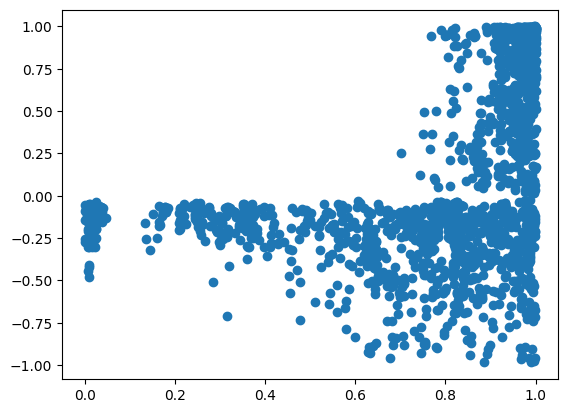

In [7]:
a = np.reshape(accuracy,-1)
q = np.reshape(quality,-1)
plt.scatter(q,a)

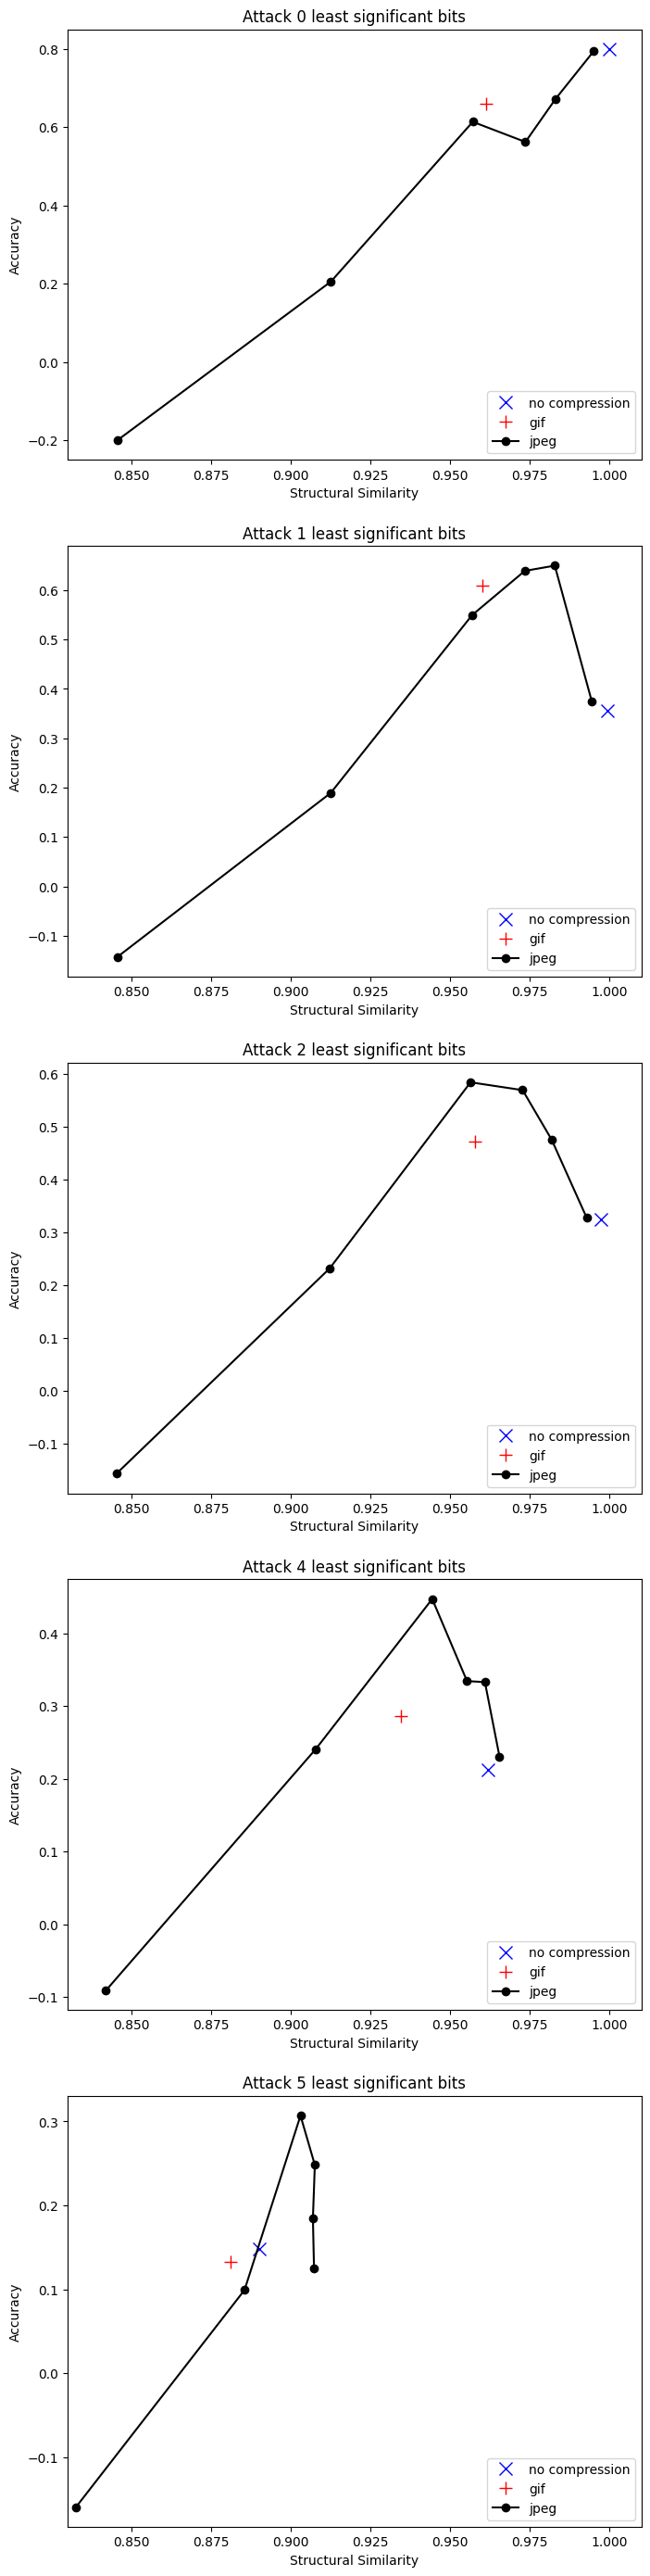

In [72]:
plt.figure(figsize=(8,35))
for ip, p in enumerate([0,1,2,4,5]):
    plt.subplot(5,1,ip+1)
    a = np.mean(accuracy[:,p,0])
    q = np.mean(quality[:,p,0])
    plt.plot(q,a,'bx',label='no compression',markersize=10)

    a = np.mean(accuracy[:,p,1])
    q = np.mean(quality[:,p,1],)
    plt.plot(q,a,'r+',label='gif',markersize=10)

    a = np.mean(accuracy[:,p,2:8],axis=0)
    q = np.mean(quality[:,p,2:8],axis=0)
    plt.plot(q,a,'-ko',label='jpeg')

    plt.legend(loc='lower right')
    plt.title("Attack "+str(p)+" least significant bits")
    plt.xlabel('Structural Similarity')
    plt.ylabel('Accuracy')
    plt.xlim([0.83,1.01])